In [46]:
import os
import sys
import torch
import numpy as np

torch.set_default_dtype(torch.float64)

from botorch.optim import optimize_acqf_discrete
from copy import deepcopy

cwd = os.getcwd()
sys.path.append("/".join(cwd.split("/")[:-2]))

from src.bax.alg.algorithms import TopK
from src.acquisition_functions.posterior_sampling import gen_posterior_sampling_batch
from src.acquisition_functions.bax_acquisition import BAXAcquisitionFunction
from src.fit_model import fit_model
# from src.performance_metrics import evaluate_performance
from src.utils import (
    generate_initial_data,
    generate_random_points,
    get_obj_vals,
    seed_torch,
    optimize_acqf_and_get_suggested_batch,
)
from src.performance_metrics import output_dist_fn_norm, output_dist_fn_jaccard

In [47]:
def create_mesh(xmin, xmax, steps=20):
    length = xmax - xmin
    # xlim = [xmin - 0.05 * length, xmax + 0.05 * length]
    # ax = torch.linspace(xlim[0], xlim[1], steps)
    ax = torch.linspace(xmin + 0.05 * length, xmax - 0.05 * length, steps)
    xx = torch.meshgrid(ax, ax, indexing="ij")
    return xx

def reshape_mesh(xx):
    x1 = xx[0].reshape(-1)
    x2 = xx[1].reshape(-1)
    return torch.stack([x1, x2], dim=1)

def himmelblau(X, minimize=False):
    a = X[:, 0]
    b = X[:, 1]
    result = (a ** 2 + b - 11) ** 2 + (a + b ** 2 - 7) ** 2
    if not minimize:
        return -result
    else:
        return result
    
def obj_func(X, domain=[-6, 6]):
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X)
    # rescale X from 0, 1 to domain
    X_rescaled = X.clone()
    X_rescaled = (domain[1] - domain[0]) * X_rescaled + domain[0]
    f_0 = himmelblau
    return f_0(X_rescaled)

def evaluate_performance(model, algo, output_gt):
    '''
    Args:
        metrics: list of PerformanceMetric
        model: GP model
    '''
    posterior_mean_func = lambda x : model.posterior(x).mean
    _, output_mf = algo.run_algorithm_on_f(posterior_mean_func)
    performance_metrics = [
        output_dist_fn_jaccard(output_mf, output_gt),
        output_dist_fn_norm(output_mf, output_gt),
    ]
    return performance_metrics, output_mf


In [48]:
num_init_points = 20
input_dim = 2
seed = 0
k = 4
domain = [-6, 6]
max_iter = 30
batch_size = 1
kwargs = {}
seed_torch(seed)


In [65]:
x_path = create_mesh(0, 1, steps=10)
x_np = reshape_mesh(x_path).numpy()
optima = np.array(
    [
        [3, 2],
        [-2.805118, 3.131312],
        [-3.779310, -3.283186],
        [3.584458, -1.848126],
    ]
)
rescaled_optima = (optima - domain[0]) / 12
x_np = np.concatenate([x_np, rescaled_optima], axis=0)
x_path = [list(x) for x in x_np]

algo = TopK({"x_path": x_path, "k": k}, verbose=False)

y_np = obj_func(x_np)
x_top_k = x_np[y_np.argsort()[-k:]]

algo_gt = algo.get_copy()
_, output_gt = algo_gt.run_algorithm_on_f(obj_func)

inputs, obj_vals = generate_initial_data(
    num_init_points=num_init_points,
    input_dim=input_dim,
    obj_func=obj_func,
    seed=0,
    **kwargs,
)

model = fit_model(
    inputs,
    obj_vals,
    model_type="gp",
    **kwargs
)

policies = ["ps", "bax"]
x_gp = {
    "ps" : inputs,
    "bax": inputs,
}
y_gp = {
    "ps" : obj_vals,
    "bax": obj_vals,
}
models = {
    "ps": deepcopy(model),
    "bax": deepcopy(model),
}

performance, output = evaluate_performance(model, algo.get_copy(), output_gt, **kwargs)
performances = {
    "ps": [performance],
    "bax": [performance],
}
_, output_mf = algo.run_algorithm_on_f(lambda x: model.posterior(x).mean)
outputs = {
    "ps": np.array(output_mf.x),
    "bax": np.array(output_mf.x)
}



In [68]:
for t in range(max_iter):
    for policy in policies:
        algo_copy = algo.get_copy()
        if policy == "ps":
            x_next = gen_posterior_sampling_batch(models[policy], algo_copy, batch_size)
        elif policy == "bax":
            acq_func = BAXAcquisitionFunction(
                model=model, 
                algo=algo_copy,
                **kwargs, 
            )
            acq_func.initialize()
            x_next, _ = optimize_acqf_discrete(acq_function=acq_func, q=batch_size, choices=torch.from_numpy(x_np), max_batch_size=100)
        
        y_next = obj_func(x_next)
        x_gp[policy] = torch.cat([x_gp[policy], x_next], dim=0)
        y_gp[policy] = torch.cat([y_gp[policy], y_next], dim=0)
        models[policy] = fit_model(
            x_gp[policy], 
            y_gp[policy], 
            model_type="gp", 
            **kwargs
        )
        performance, output = evaluate_performance(models[policy], algo.get_copy(), output_gt, **kwargs)
        performances[policy].append(performance)
        outputs[policy] = np.concatenate((outputs[policy], np.array(output.x)), axis=0)

        print(f"Policy: {policy}, Iter: {t}, Performance: {performances[policy][-1]} \n")

Policy: ps, Iter: 0, Performance: [0.8571428571428572, 0.6591301353530905] 

Policy: bax, Iter: 0, Performance: [0.8571428571428572, 0.6591301353530905] 

Policy: ps, Iter: 1, Performance: [0.8571428571428572, 0.6591301353530905] 

Policy: bax, Iter: 1, Performance: [0.8571428571428572, 0.6591301353530905] 

Policy: ps, Iter: 2, Performance: [0.6666666666666667, 0.6227238190870055] 

Policy: bax, Iter: 2, Performance: [0.6666666666666667, 0.73209639572674] 

Policy: ps, Iter: 3, Performance: [0.6666666666666667, 0.5141986938511437] 

Policy: bax, Iter: 3, Performance: [0.6666666666666667, 0.73209639572674] 

Policy: ps, Iter: 4, Performance: [1.0, 0.6460452055025295] 

Policy: bax, Iter: 4, Performance: [0.6666666666666667, 0.6227238190870055] 

Policy: ps, Iter: 5, Performance: [0.8571428571428572, 0.6591301353530905] 

Policy: bax, Iter: 5, Performance: [0.6666666666666667, 0.5462100525667504] 

Policy: ps, Iter: 6, Performance: [0.8571428571428572, 0.6591301353530905] 

Policy: bax,

In [70]:
PATH = f"{os.getcwd()}/demo"

# To save
os.makedirs(PATH, exist_ok=True)
for policy in policies:
    # save x_gp
    x_gp_path = f"{PATH}/x_{policy}_{seed}.txt"
    np.savetxt(x_gp_path, x_gp[policy].numpy())

    x_output_path = f"{PATH}/output_{policy}_{seed}.txt"
    np.savetxt(x_output_path, outputs[policy])

# To read
# x_gp = {}
# for policy in policies:
#     x_gp_path = f"{PATH}/x_{policy}_{seed}.txt"
#     x_gp[policy] = torch.tensor(np.loadtxt(x_gp_path))

# x_output = {}
# for policy in policies:
#     x_output_path = f"{PATH}/output_{policy}_{seed}.txt"
#     x_output[policy] = np.loadtxt(x_output_path)


In [71]:
import matplotlib.pyplot as plt
file_format = "pdf"

In [72]:
himmelblau_opt = np.array(
        [
            [3, 2],
            [-2.805118, 3.283186],
            [-3.779310, -3.283186],
            [3.584458, -1.848126],
        ]
    )
domain = [-6, 6]
himmelblau_opt = (himmelblau_opt - domain[0]) / (domain[1] - domain[0])
x_mesh = create_mesh(-0.1, 1.1, steps=100)
z = obj_func(reshape_mesh(x_mesh))
z = z.reshape(x_mesh[0].shape)


In [73]:
def plot(policy, file_format="pdf", show_title=False):
    colors = {
        "ps" : "b",
        "bax" : "g",
    }
    fig, ax = plt.subplots(
        figsize=(8, 8)
    )
    ax.contourf(x_mesh[0], x_mesh[1], z, cmap="YlOrRd", alpha=0.6, levels=40)
    ax.scatter(
        x_np[:, 0],
        x_np[:, 1],
        c="#6B3E26",
        marker=".",
        s=5,
        alpha=0.5,
        label="Discrete Set",
    )
    ax.scatter(
        x_top_k[:, 0], 
        x_top_k[:, 1], 
        c="red", 
        marker="*",
        s=500,
        label="Top k",
    )
    ax.scatter(
        x_gp[policy][num_init_points:, 0], 
        x_gp[policy][num_init_points:, 1], 
        c=colors[policy], 
        marker="o",
        alpha = 0.2,
        s=100,
        label="Sampled",
    )
    # ax.scatter(
    #     x_gp[policy][-batch_size:, 0],
    #     x_gp[policy][-batch_size:, 1],
    #     c="black",
    #     marker="o",
    #     alpha = 0.5,
    #     s = 100,
    #     label="Last Selected",
    # )
    ax.scatter(
        outputs[policy][-k:, 0],
        outputs[policy][-k:, 1],
        c= "#ff7f0e",
        marker="P",
        s = 100,
        label="Algorithm Output",
    )
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=5)
    if show_title:
        if policy == "ps":
            ax.set_title("Posterior Sampling")
        elif policy == "bax":
            ax.set_title("Expected Information Gain", )
    plt.tight_layout()
    plt.savefig(
        f"{PATH}/{policy}_{seed}.{file_format}",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()

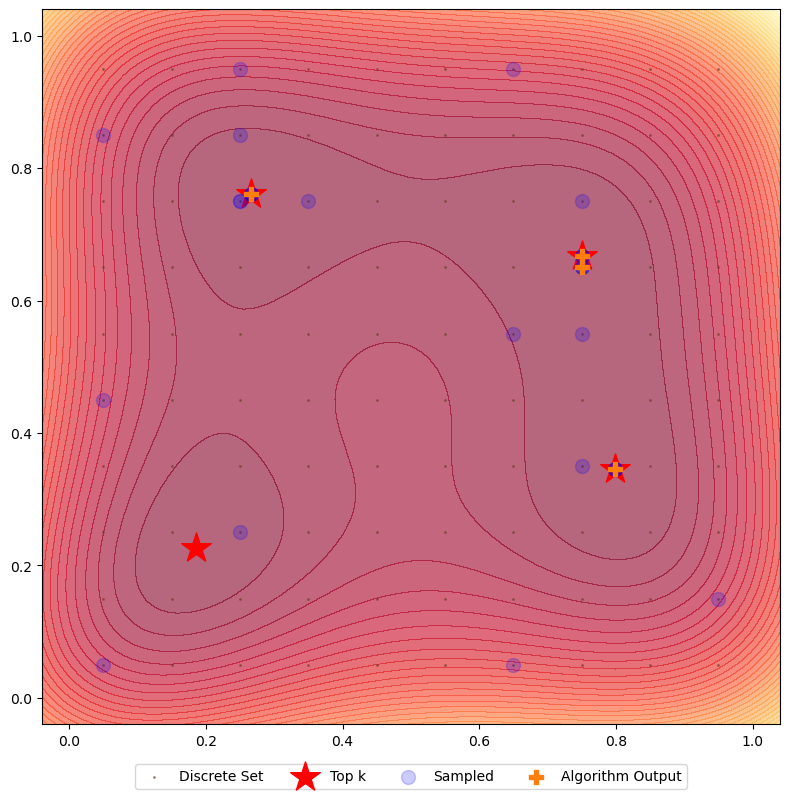

In [74]:
plot("ps", file_format)

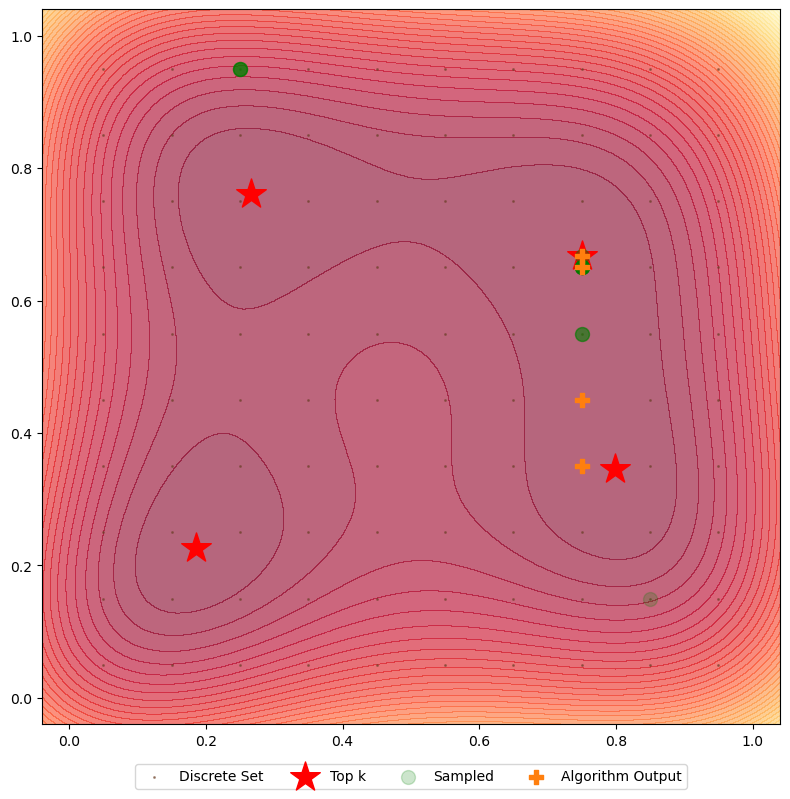

In [75]:
plot("bax", file_format)


In [77]:
x_gp["bax"].T

tensor([[0.9701, 0.4594, 0.6450, 0.1786, 0.5813, 0.4529, 0.3553, 0.4818, 0.4073,
         0.6650, 0.2104, 0.1097, 0.2260, 0.5875, 0.7454, 0.8099, 0.1959, 0.4815,
         0.5720, 0.7961, 0.7500, 0.7500, 0.7500, 0.7500, 0.2500, 0.8500, 0.2500,
         0.7500, 0.7500, 0.7500, 0.2500, 0.7500, 0.7500, 0.7500, 0.7500, 0.2500,
         0.2500, 0.7500, 0.7500, 0.7500, 0.7500, 0.2500, 0.7500, 0.7500, 0.7500,
         0.2500, 0.7500, 0.7500, 0.7500, 0.7500],
        [0.7078, 0.9207, 0.7911, 0.3511, 0.2882, 0.1768, 0.6219, 0.4408, 0.2054,
         0.7849, 0.6767, 0.5238, 0.5582, 0.6819, 0.2277, 0.6306, 0.1527, 0.9175,
         0.4808, 0.3680, 0.6500, 0.6500, 0.5500, 0.6500, 0.9500, 0.1500, 0.9500,
         0.6500, 0.6500, 0.6667, 0.9500, 0.5500, 0.6500, 0.6500, 0.6500, 0.9500,
         0.9500, 0.6500, 0.6500, 0.6500, 0.6500, 0.9500, 0.6667, 0.6500, 0.6500,
         0.9500, 0.6500, 0.5500, 0.5500, 0.6500]])

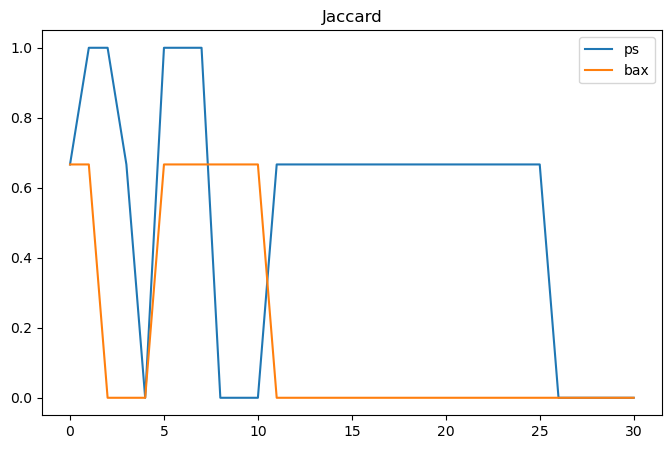

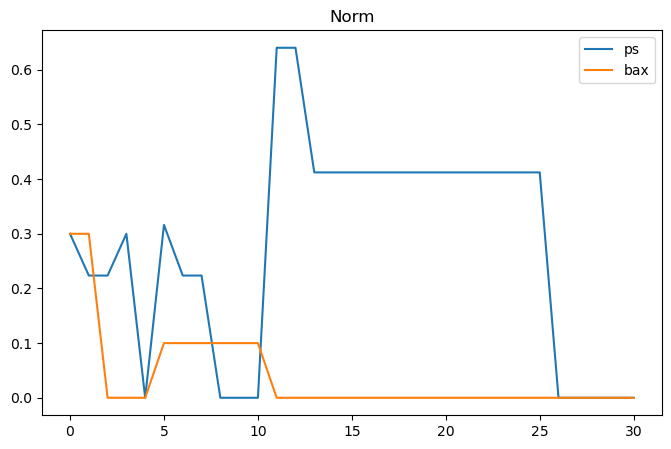

In [143]:
# graph performance 

metrics = [
    "Jaccard",
    "Norm"
]

for policy in policies:
    performances[policy] = np.vstack(performances[policy])
for i, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(8, 5))
    for policy in policies:
        ax.plot(performances[policy][:, i], label=policy)
    ax.legend()
    ax.set_title(metric)
    plt.show()

---

In [ ]:
ps_outputs = {}
n_samp = 30
for t in range(max_iter):
    for policy in policies:
        algo_copy = algo.get_copy()
        if policy == "ps":
            x_next = gen_posterior_sampling_batch(models[policy], algo_copy, batch_size)
        elif policy == "bax":
            acq_func = BAXAcquisitionFunction(
                model=model, 
                algo=algo_copy,
                **kwargs, 
            )
            acq_func.initialize()
            x_next, _ = optimize_acqf_discrete(acq_function=acq_func, q=batch_size, choices=torch.from_numpy(x_np), max_batch_size=100)
        
        y_next = obj_func(x_next)
        x_gp[policy] = torch.cat([x_gp[policy], x_next], dim=0)
        y_gp[policy] = torch.cat([y_gp[policy], y_next], dim=0)
        models[policy] = fit_model(
            x_gp[policy], 
            y_gp[policy], 
            model_type="gp", 
            **kwargs
        )
        performance, output = evaluate_performance(models[policy], algo.get_copy(), output_gt, **kwargs)
        performances[policy].append(performance)
        outputs[policy] = np.concatenate((outputs[policy], np.array(output.x)), axis=0)

        print(f"Policy: {policy}, Iter: {t}, Performance: {performances[policy][-1]} \n")
    